# Modellierung der MPA-Sensordaten

In [3]:
!pip install xgboost

     |████████████████████████████████| 173.5 MB 68 kB/s              


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import datetime as dt
import sys
sys.path.append('..')
from multiprocess import Pool
from feature_extract import extract_highest_amplitude_features_with_mp
import xgboost as xgb
import optuna
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = None

In [2]:
data = pd.read_table('data_mpa.txt', sep=' ')

In [3]:
# Resample data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

## Extraction of Maximum Features per Sensor

In [4]:
data = extract_highest_amplitude_features_with_mp(df=data, sensor_types=[['M01', 'M02', 'M03', 'M04']],
                                                  create_one_sensor_feature=True, n_processes=4, 
                                                  keep_columns=False)

INFO || Extracting Max Features for types: ['M01', 'M02', 'M03', 'M04']


In [5]:
data.head(3)

,start_time,packnr,velocity,size_mm,max_centroid_frequency_M,max_centroid_frequency2_M,max_median_freq_M,max_flash_ind_M,max_cv_M,max_iqa_M,max_mab_M,max_imp_M,max_len_M
0,2019-09-18 14:52:07,12,2.40,95.5,2930.137074,3107.080795,3117.579309,0.003990,1.165440,0.000053,0.290108,1,42
1,2020-09-22 13:50:33,14,1.70,28.1,2656.734602,2825.463736,2817.582730,0.001214,0.773513,0.003530,3.005457,5,52
2,2018-09-25 09:50:04,19,1.55,12.3,3389.969821,3457.660467,3395.520535,0.001370,0.948615,0.000052,0.381613,2,40


In [6]:
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
feature_cols.remove('start_time')
feature_cols.remove('packnr')
X, y = data[feature_cols], data['size_mm']
X.head(2)

,velocity,max_centroid_frequency_M,max_centroid_frequency2_M,max_median_freq_M,max_flash_ind_M,max_cv_M,max_iqa_M,max_mab_M,max_imp_M,max_len_M
0,2.4,2930.137074,3107.080795,3117.579309,0.003990,1.165440,0.000053,0.290108,1,42
1,1.7,2656.734602,2825.463736,2817.582730,0.001214,0.773513,0.003530,3.005457,5,52


## Train-Test Split

In [7]:
make_val_set = False

if make_val_set:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)
    y_train, y_test = np.log(y_train), np.log(y_test)
else:
    X_train = X.copy()
    y_train = np.log(y.copy())

## XGBoost

https://xgboost.readthedocs.io/en/latest/python/python_api.html

https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters

https://xgboost.readthedocs.io/en/latest/parameter.html

To-Do:
- Anpassen auf Regression (Siehe Parameter in Documentation)
- Auf GPU Runnen in Jupyterhub CSCS
- Durchläufe mehrerer Studies

### Max-Parameter

In [55]:
def objective(trial):
    #dtrain = xgb.DMatrix(X_train, label=y_train)
    #dvalid = xgb.DMatrix(X_test, label=y_test)
    
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 15, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    scores = cross_val_score(estimator=xgb.XGBRegressor(**param), 
                             X=X_train, y=y_train, cv=5, scoring='r2')
    score = np.mean(scores)    
    return score

In [22]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600, n_jobs=-1)

[I 2021-11-17 22:01:51,876] A new study created in memory with name: no-name-71a13824-cd10-4a70-96f6-8b5a50e42383
[I 2021-11-17 22:02:12,270] Trial 19 finished with value: 0.5487311196385555 and parameters: {'booster': 'gblinear', 'lambda': 2.9159432350167654e-07, 'alpha': 2.6385483036983837e-05, 'subsample': 0.9039703569841224, 'colsample_bytree': 0.8467655501487565}. Best is trial 19 with value: 0.5487311196385555.
[I 2021-11-17 22:02:12,341] Trial 18 finished with value: 0.5511144293408545 and parameters: {'booster': 'gblinear', 'lambda': 1.4557909084555968e-05, 'alpha': 5.4523416746360104e-05, 'subsample': 0.711193920847595, 'colsample_bytree': 0.3337340702074493}. Best is trial 18 with value: 0.5511144293408545.
[I 2021-11-17 22:02:12,490] Trial 6 finished with value: 0.5554578241669369 and parameters: {'booster': 'gblinear', 'lambda': 9.45811256983554e-06, 'alpha': 0.47847818382366597, 'subsample': 0.4534389943706527, 'colsample_bytree': 0.7570260551429497}. Best is trial 6 with 

In [57]:
for _ in range(10):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600, n_jobs=-1)
    
    # Save best params
    now = dt.datetime.now().strftime('%m.%d_%H:%M')
    with open(now + '__best_params_xgboost.pkl', 'wb') as pkl_file:
        pickle.dump(study.best_trial, pkl_file)

[I 2021-11-18 07:16:14,987] A new study created in memory with name: no-name-578b17a1-2901-4e45-8097-8552c6f8e7bf
[I 2021-11-18 07:16:35,984] Trial 3 finished with value: 0.553237357675242 and parameters: {'booster': 'gblinear', 'lambda': 0.01368478497392824, 'alpha': 0.0003740775595529488, 'subsample': 0.656377185845872, 'colsample_bytree': 0.678376840711308}. Best is trial 3 with value: 0.553237357675242.
[I 2021-11-18 07:16:36,587] Trial 17 finished with value: 0.5536548484101426 and parameters: {'booster': 'gblinear', 'lambda': 0.05033248148728658, 'alpha': 1.405614599688922e-08, 'subsample': 0.8755780848063162, 'colsample_bytree': 0.3965431336960872}. Best is trial 17 with value: 0.5536548484101426.
[I 2021-11-18 07:16:36,897] Trial 4 finished with value: 0.5507945265542897 and parameters: {'booster': 'gblinear', 'lambda': 0.0032399119660338196, 'alpha': 0.11337994111573693, 'subsample': 0.6934522375741143, 'colsample_bytree': 0.6623654930897376}. Best is trial 17 with value: 0.55

In [59]:
import os

In [63]:
params = []
for file in os.listdir('results'):
    with open('./results/'+file, 'rb') as pkl_file:
        params.append(pickle.load(pkl_file))

In [75]:
trial_results = [i.values[0] for i in params]
trial_results = pd.Series(dict(zip(np.arange(len(trial_results)), trial_results)))
trial_results

0    0.754951
1    0.754259
2    0.752681
3    0.749490
4    0.754364
5    0.731073
6    0.747866
7    0.742040
8    0.737327
9    0.746145
dtype: float64

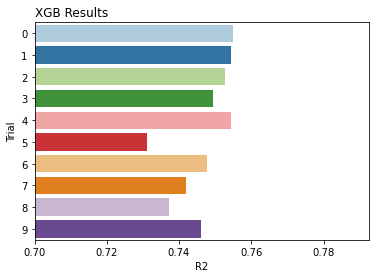

In [88]:
sns.set_palette('Paired')
p = sns.barplot(x=trial_results,y=trial_results.index, orient='h')
p.set_title('XGB Results', loc='left')
p.set_xlabel('R2')
p.set_ylabel('Trial')
plt.xlim(.7)
plt.show()

In [91]:
xgbooster = xgb.XGBRegressor(**params[4].params)

In [95]:
scores = cross_val_score(estimator=xgbooster, 
                         X=X, y=y, cv=10, scoring='r2', 
                         n_jobs=10, verbose=2)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 12.9min remaining: 30.0min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 12.9min finished


In [96]:
scores

array([0.76356101, 0.76483324, 0.74574054, 0.75844448, 0.75776629,
       0.75277436, 0.76432373, 0.75625822, 0.7548562 , 0.74362796])

[CV] END .................................................... total time=12.8min
[CV] END .................................................... total time=12.8min
[CV] END .................................................... total time=12.8min
[CV] END .................................................... total time=12.8min
[CV] END .................................................... total time=12.8min
[CV] END .................................................... total time=12.8min
[CV] END .................................................... total time=12.8min
[CV] END .................................................... total time=12.8min
[CV] END .................................................... total time=12.8min
[CV] END .................................................... total time=12.8min


In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

In [99]:
xgbooster.fit(X_train, y_train)

XGBRegressor(alpha=6.742833057746334e-06, base_score=0.5, booster='dart',
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.5135702885538609, enable_categorical=False,
             eta=0.06178492108667007, gamma=1.1156994480892872e-08, gpu_id=-1,
             grow_policy='lossguide', importance_type=None,
             interaction_constraints='', lambda=0.8468666938137726,
             learning_rate=0.0617849194, max_delta_step=0, max_depth=11,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=24, normalize_type='forest',
             num_parallel_tree=1, predictor='auto', random_state=0,
             rate_drop=1.1002327719892883e-08, reg_alpha=6.74283319e-06,
             reg_lambda=0.846866667, sample_type='weighted', ...)

In [125]:
y_pred = xgbooster.predict(X_test)

In [242]:
def plot_error_per_cat(y_true, y_pred, show_strip=True, show_outliers=False):
    """
    
    """
    fig = plt.subplots(figsize=(10, 5))
    sns.set_palette('Greens', 15)
    sns.set_style('darkgrid')
    p = sns.boxplot(y=y_pred, x=y_test, showfliers=show_outliers)
    if show_strip:
        p2 = sns.stripplot(y=y_pred, x=y_test, alpha=.5, color='grey', size=3)
    p.set_xlabel('True')
    p.set_ylabel('Predicted')
    p.set_title('True vs. Predicted per Category', loc='left')
    plt.show()

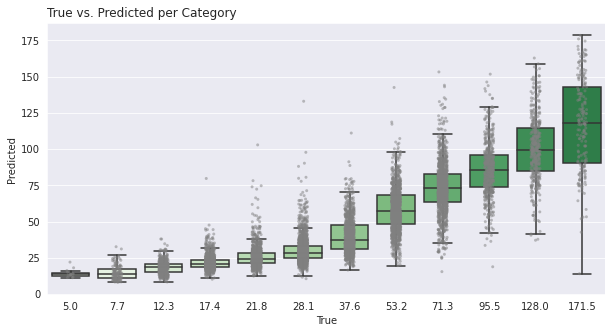

In [243]:
plot_error_per_cat(y_test, y_pred)

In [314]:
def plot_predictions_to_nearest_class_heatmap(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Plots a Confusion Matrix of the predictions mapped to the nearest Grainsize Class.
    The actual Regression Problem was abstracted to a classification problem to see which 
    values were mixed up a lot.
    
    params:
    ---------
    y_true: np.ndarray
        Array of True labels
    
    y_pred: np.ndarray
        Array of predicted labels
    
    returns:
    -------------
    plt.figure
    
    """
    y_true_cluster = y_true.astype('float32').reshape(-1,1)
    y_pred_cluster = y_pred.astype('float32').reshape(-1,1)
    
    cluster = KMeans(n_clusters=len(np.unique(y_true_cluster)))
    cluster.fit(y_true_cluster)
    
    y_true_cluster = cluster.predict(y_true_cluster)
    y_pred_cluster = cluster.predict(y_pred_cluster)
    
    fig = plt.subplots(figsize=(10, 5))
    
    p = sns.heatmap(confusion_matrix(y_true=y_test_cluster, y_pred=y_pred_cluster), 
                    cmap='Reds',linewidths=.1, linecolor='black', annot=True, fmt='2d')
    p.set_xlabel('Predicted')
    p.set_ylabel('True')
    p.set_xticklabels(np.unique(y_test), rotation=30)
    p.set_yticklabels(np.unique(y_test), rotation=30)
    plt.title('Predictions mapped to nearest Grainsize Class with KMeans. KMeans Centers defined as Grainsize-classes of True Values', fontsize=8)
    plt.suptitle('Confusion Matrix')
    plt.show()

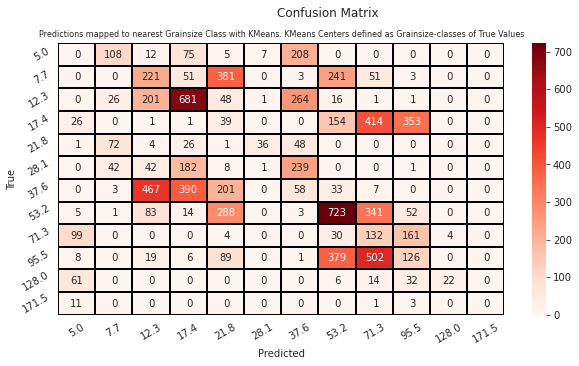

In [313]:
plot_predictions_to_nearest_class_heatmap(y_true=y_test.to_numpy(), y_pred=y_pred)

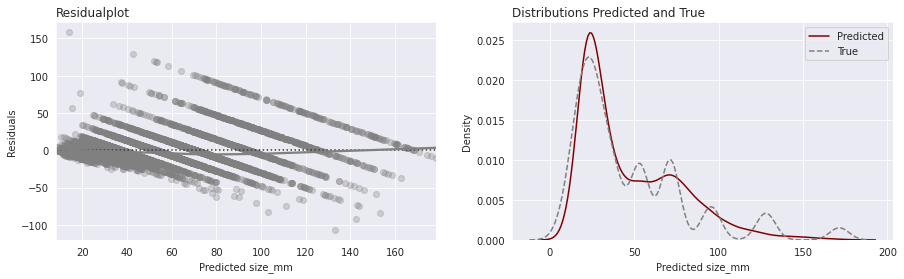

In [352]:
fig = plt.subplots(figsize=(15, 4))
sns.set_palette('Greens', 2)

plt.subplot(1,2,1)
p = sns.residplot(x=y_pred, y=y_test, color='grey', lowess=True, scatter_kws=dict(alpha=.3))
p.set_title('Residualplot', loc='left')
p.set_xlabel('Predicted size_mm')
p.set_ylabel('Residuals')

plt.subplot(1,2,2)
p = sns.kdeplot(x=y_pred, label='Predicted', color='maroon', cumulative=False)
p = sns.kdeplot(x=y_test, label='True', color='grey', linestyle='--', cumulative=False)
plt.legend()
p.set_title('Distributions Predicted and True', loc='left')
p.set_xlabel('Predicted size_mm')
p.set_ylabel('Density')

plt.show()

In [360]:
from scipy.stats import ks_2samp
from scipy.special import kl_div

In [354]:
ks_2samp(data1=y_test, data2=y_pred)

KstestResult(statistic=0.13221902017291065, pvalue=1.772474329576668e-66)

In [ ]:
ks_2samp(data1=y_pred, data2=y_pred)

In [363]:
np.mean(kl_div(y_test.to_numpy(), y_pred))

2.2544091817263814

In [364]:
np.mean(kl_div(y_pred, y_pred))

0.0

In [346]:
tmp = pd.DataFrame(data={'true':y_test, 'pred':y_pred})

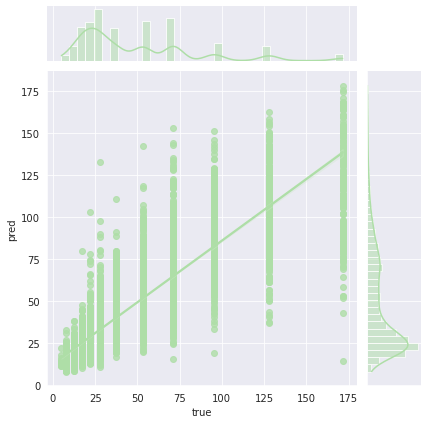

In [347]:
sns.jointplot(data=tmp, x='true', y='pred', kind='reg')

### Polynomial Features

In [9]:
def objective(trial):
    #dtrain = xgb.DMatrix(X_train, label=y_train)
    #dvalid = xgb.DMatrix(X_test, label=y_test)
    
    poly_transform = PolynomialFeatures(degree=trial.suggest_int('degree', 1, 2), 
                                        interaction_only=trial.suggest_categorical('interaction_only', [True, False]))
    X_transformed = poly_transform.fit_transform(X_train)
    
    
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "exact",
        ''
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 15, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    scores = cross_val_score(estimator=xgb.XGBRegressor(**param), 
                             X=X_transformed, y=y_train, cv=5, scoring='r2')
    score = np.mean(scores)    
    return score

In [ ]:
for _ in range(10):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=500, timeout=1000, n_jobs=-1)
    
    # Save best params
    now = dt.datetime.now().strftime('%m.%d_%H:%M')
    with open('./results/' + now + '__best_params_xgboost.pkl', 'wb') as pkl_file:
        pickle.dump(study.best_trial, pkl_file)

[I 2021-11-18 17:35:16,341] A new study created in memory with name: no-name-84d3a309-0cd8-45a9-a284-f882dee87cf8
[I 2021-11-18 17:35:41,357] Trial 9 finished with value: 0.5421857106442527 and parameters: {'degree': 1, 'interaction_only': True, 'booster': 'gblinear', 'lambda': 7.256258514839575e-06, 'alpha': 3.719131715450237e-08, 'subsample': 0.21248544773538028, 'colsample_bytree': 0.8628814970771761}. Best is trial 9 with value: 0.5421857106442527.
[I 2021-11-18 17:35:41,504] Trial 6 finished with value: 0.5269833172990624 and parameters: {'degree': 1, 'interaction_only': True, 'booster': 'gblinear', 'lambda': 0.08250161046357508, 'alpha': 1.008546034719156e-08, 'subsample': 0.2309612419194342, 'colsample_bytree': 0.9022883662172232}. Best is trial 9 with value: 0.5421857106442527.
[I 2021-11-18 17:35:41,817] Trial 12 finished with value: 0.5486864737933697 and parameters: {'degree': 1, 'interaction_only': True, 'booster': 'gblinear', 'lambda': 1.0166329411339947e-07, 'alpha': 1.44